# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

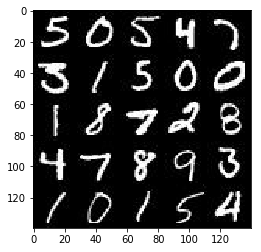

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

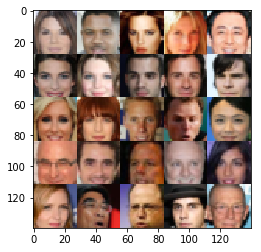

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 

    input_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim),name='input_z')
    learn_rate=tf.placeholder(tf.float32,name='learn_rate')


    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=.1
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input images are 28x28x3, input layer does not have batch normalization and we pass it to get a leaky relu output
        # This will become 14x14x64 when we pass in 64 filters 
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        #All hidden layers will be of the form: convolution > batch norm > leaky ReLU
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm_layer_2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*batch_norm_layer_2, batch_norm_layer_2) #7x7x128
        
        #All hidden layers will be of the form: convolution > batch norm > leaky ReLU
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm_layer_3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*batch_norm_layer_3, batch_norm_layer_3) #4x4x256
        
        #Now we need to flatten it, no batch normalization here.. 
        flatten_result = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten_result, 1)
        output = tf.sigmoid(logits)
        

    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # 7x7x512
        
        # Layer 2
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=1, padding='SAME', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # 7x7x256
        
        # Layer 3
        g3 = tf.layers.conv2d_transpose(g2, 64, 5, strides=2, padding='SAME', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        # 14x14x128
        
        # Layer 4
        g4 = tf.layers.conv2d_transpose(g3, 32, 5, strides=2, padding='SAME', activation=None)
        g4 = tf.layers.batch_normalization(g4, training=is_train)
        g4 = tf.maximum(alpha * g4, g4)   
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(g4, out_channel_dim, 3, strides=1, padding='SAME', activation=None)
        # shape = 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)    
    
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 1
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr: learning_rate})
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.7056
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.3614
Epoch 1/2... Discriminator Loss: 2.8690... Generator Loss: 8.3980
Epoch 1/2... Discriminator Loss: 4.5900... Generator Loss: 0.0201
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 2.1169
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 2.2455
Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.1446


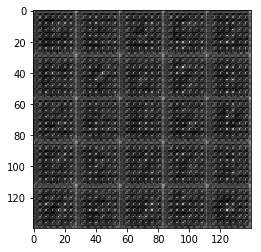

Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 1.2511
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.0685
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 1.6059
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.4018


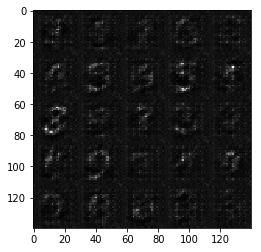

Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.5300
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 1.3068
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.5085
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.8826


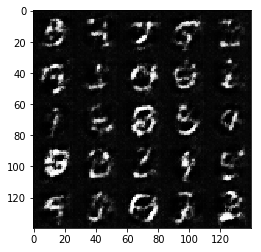

Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.9756
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.1193
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.5059


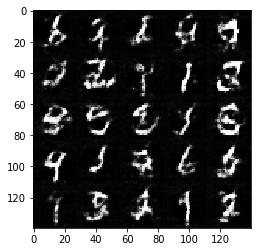

Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.0807
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.1069
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 2.0832
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.4380... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 1.0171


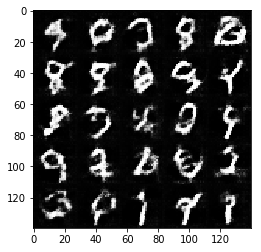

Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 1.1936
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.7037
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.2664
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 0.7735


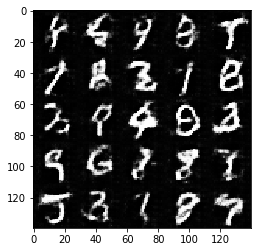

Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 0.8688


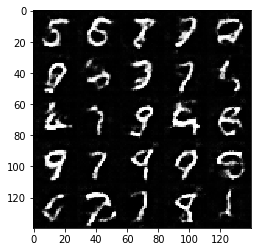

Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 1.2160
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 2.0067
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 1.5112
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.9649


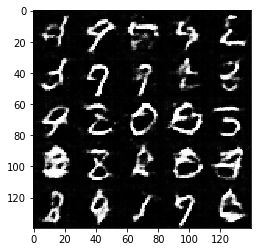

Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 2.0407
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.8877


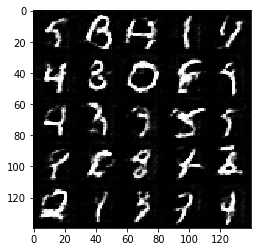

Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.6103... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 1.1693
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.7119... Generator Loss: 0.3343


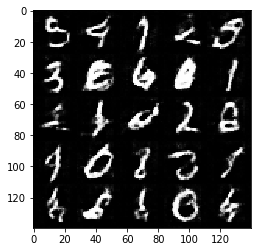

Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.4376
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.3934


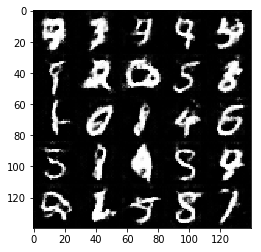

Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.3008
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 2.0670
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.0680
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.3618
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.2756
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.8763


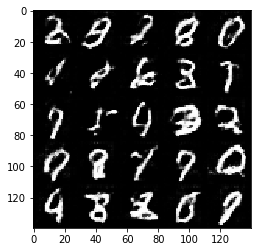

Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.3318
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.8884
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.7637... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 1.3279
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.9427
Epoch 2/2.

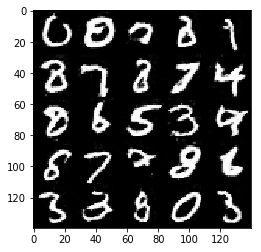

Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.0984
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.2520
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.8369


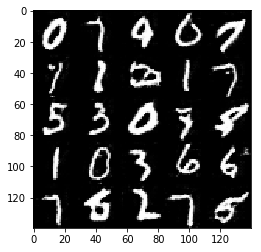

Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.0648... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.1008
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.8294


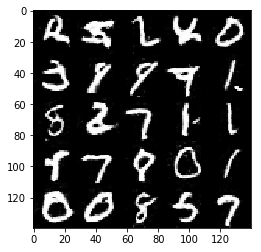

Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 0.9790
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.4483
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.9808
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.6470


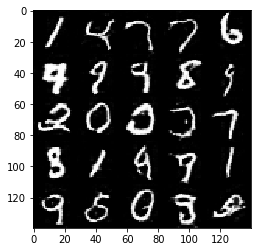

Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 1.2154
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.0716
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.8702
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.8326


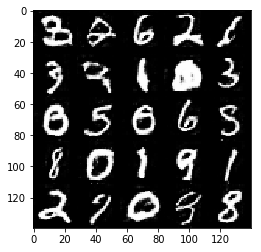

Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.4025
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 1.7743... Generator Loss: 0.3737
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.7453


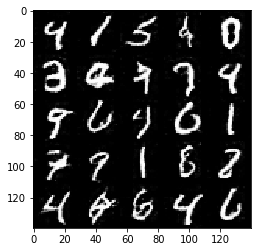

Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.2847
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.8706


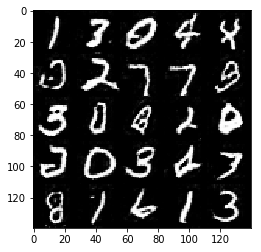

Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.1615
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 1.6305
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 1.1802
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.9319


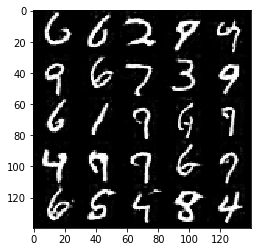

Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.5018
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.0931
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.4505
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.9953


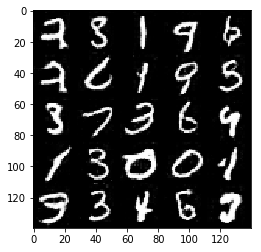

Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.9084
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.5763


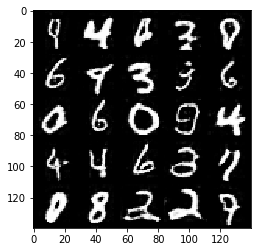

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.7368
Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 1.0757


In [ ]:
batch_size = 32
z_dim = 64
learning_rate = 0.0002
beta1 = .5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 5.7663
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 6.5026
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 4.9734
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.5181
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 7.2727
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 5.2258
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 2.1829
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.5623


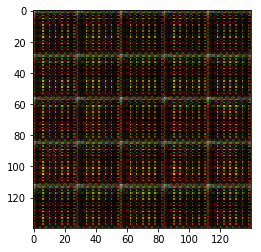

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.9515
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.3043
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7951


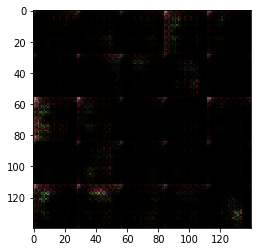

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 2.0759
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.9693
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.3038


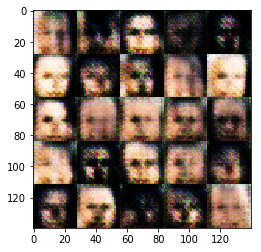

Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.6627
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.5195


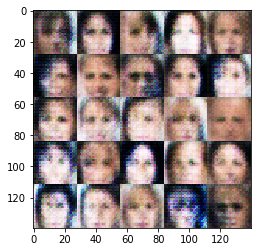

Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6916


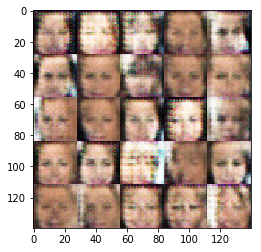

Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6969


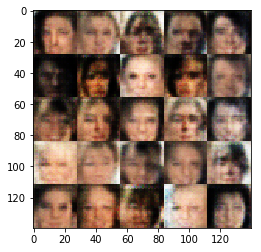

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.0176


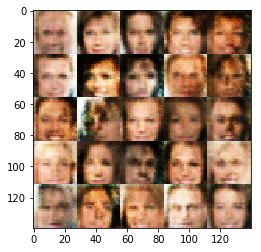

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.9299


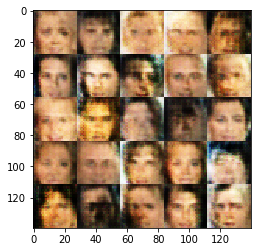

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.0259


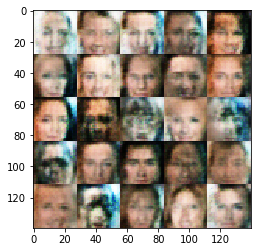

Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7611


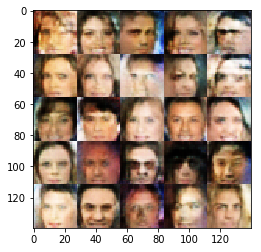

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8172


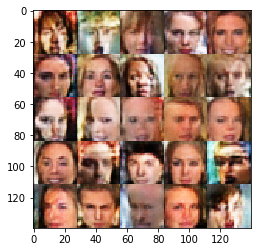

Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6163


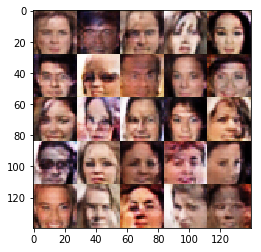

Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.4802


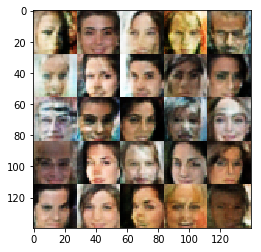

Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6659


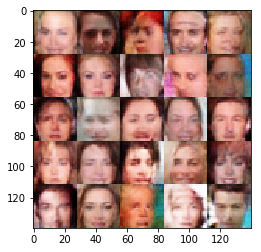

Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.1823


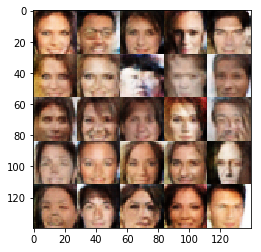

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.8501


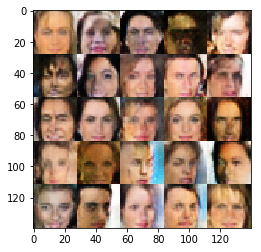

Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9279


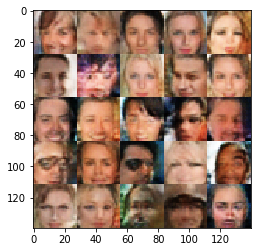

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6862


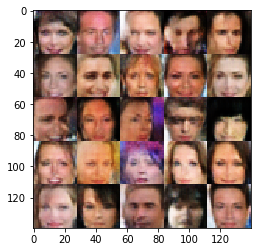

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6187


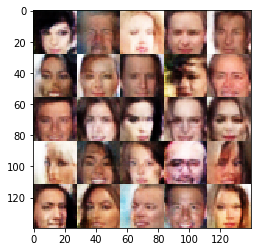

Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.1761


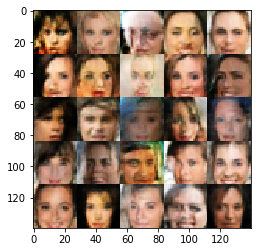

Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6771


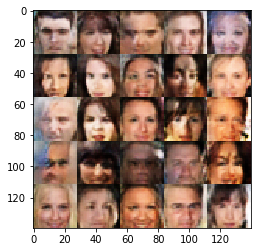

Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6180


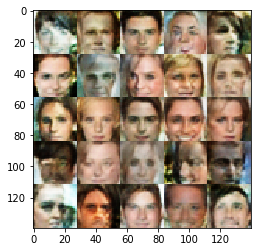

Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9319


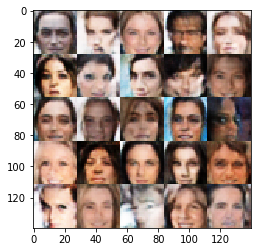

Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6787


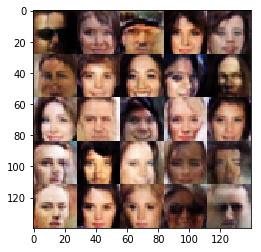

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7738


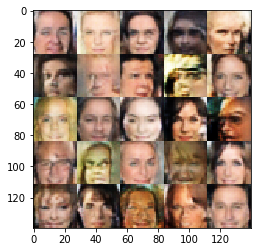

Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5824


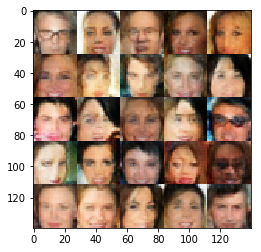

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7360


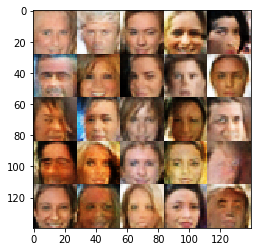

Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5710


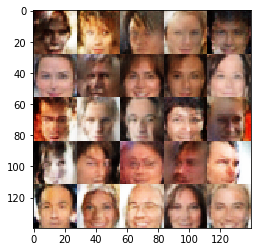

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7387


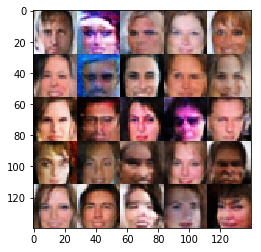

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.9319


In [ ]:
batch_size = 32
z_dim = 64
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
print("ldldldl")

ldldldl


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.